# **Categorizing Customer df_reviews**

## **Import Packages and Data**

In [1]:
# Import packages
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set style
sns.set_theme(style="whitegrid")

In [3]:
# Import data
df_reviews = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/imdb_reviews.tsv', 
                      sep = '\t', parse_dates=True)

In [4]:
# Data info
print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  float64
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: float64(2

In [5]:
# Data head
display(df_reviews.sample(15))

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
35355,tt0239020,movie,The Cave,De grot,2001,\N,90,0,"Crime,Mystery,Romance",6.4,646.0,I saw this movie by accident yesterday at a ci...,2,neg,0,train,3179
43577,tt0094142,movie,Throw Momma from the Train,Throw Momma from the Train,1987,\N,88,0,"Comedy,Crime,Thriller",6.3,32595.0,You don't see the meaning of the title till mu...,8,pos,1,test,8874
18833,tt0065916,movie,Joe,Joe,1970,\N,107,0,"Drama,Thriller",6.8,2696.0,New Yorkers contemporaneous with this film wil...,8,pos,1,test,7885
45140,tt0428251,movie,Venom,Venom,2005,\N,87,0,Horror,4.6,9451.0,"Yes, said title line does actually appear in t...",3,neg,0,test,6876
42464,tt0351887,movie,The Twins Effect,Chin gei bin,2003,\N,107,0,"Action,Comedy,Horror",5.5,4677.0,If you go into the Twins Effect looking for a ...,8,pos,1,test,10947
16745,tt0101120,tvSeries,Home Improvement,Home Improvement,1991,1999,22,0,"Comedy,Family",7.2,38554.0,this show disturbs me. it takes up slots on ni...,3,neg,0,test,3444
28067,tt0780595,movie,Redline,Redline,2007,\N,95,0,Action,4.0,8493.0,Apparently Hollywood is just handing out money...,1,neg,0,train,7145
26352,tt0069089,movie,Pink Flamingos,Pink Flamingos,1972,\N,93,0,"Comedy,Crime",6.1,21347.0,"You know the saying ""Curiosity Killed The Cat""...",10,pos,1,test,6124
8334,tt0101628,movie,Critters 4,Critters 4,1992,\N,87,0,"Horror,Sci-Fi",4.1,6587.0,I just do not see what is so bad about this mo...,10,pos,1,test,11879
36107,tt0092843,movie,The Dead,The Dead,1987,\N,83,0,Drama,7.3,6907.0,John Huston made many remarkable and memorable...,10,pos,1,test,12306


### Initial data observations

The dataset contains 47331 observations and 16 columns representing movie df_df_df_reviews and their classification, positive or negative. Runtime_minutes needs to be converted to int64. There are no missing values.

## **Prepare Data**

### Fix data types

In [6]:
# Check values of runtime
display(sorted(df_reviews['runtime_minutes'].unique()))

['1',
 '10',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '11',
 '110',
 '111',
 '112',
 '113',
 '114',
 '1140',
 '115',
 '116',
 '117',
 '118',
 '119',
 '12',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '13',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '14',
 '140',
 '141',
 '142',
 '143',
 '144',
 '145',
 '146',
 '147',
 '148',
 '149',
 '15',
 '150',
 '151',
 '152',
 '153',
 '154',
 '155',
 '156',
 '157',
 '159',
 '16',
 '160',
 '161',
 '162',
 '163',
 '164',
 '165',
 '166',
 '167',
 '168',
 '169',
 '17',
 '170',
 '171',
 '172',
 '173',
 '174',
 '175',
 '176',
 '177',
 '178',
 '179',
 '18',
 '180',
 '181',
 '183',
 '185',
 '186',
 '188',
 '189',
 '19',
 '190',
 '192',
 '194',
 '197',
 '199',
 '2',
 '20',
 '200',
 '201',
 '202',
 '204',
 '208',
 '21',
 '210',
 '211',
 '212',
 '215',
 '216',
 '217',
 '219',
 '22',
 '222',
 '225',
 '229',
 '23',
 '230',
 '232',
 '233',
 '239',
 

Missing values for runtime were entered as '\\N', which is causing the data to be mis-typed as object. Changing '\\N' to np.nan will allow the variable to be converted to to float64.

In [7]:
# Replace '\\N' with np.nan
df_reviews['runtime_minutes'] = df_reviews['runtime_minutes'].replace('\\N', np.nan)

# Convert runtime to int64
df_reviews['runtime_minutes'] = df_reviews['runtime_minutes'].astype('float')

# Display info
print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  46843 non-null  float64
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  float64
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: float64(3

Runtime_minutes is converted to float.

### Check for duplicates

In [8]:
# Check for full duplicates
duplicates_count = df_reviews.duplicated().sum()

print(f'Number of full duplicates: {duplicates_count}')

Number of full duplicates: 0


There are no fully duplicate rows.

In [9]:
# Check for review duplicates
review_duplicates = df_reviews['review'].duplicated().sum()

print(f'Number of duplicated review texts: {review_duplicates}')

Number of duplicated review texts: 91


There are 91 duplicated df_reviews. Print rows to further inspect the duplication.

In [10]:
# Print duplicated rows
duplicate_review_text = df_reviews['review'].duplicated(keep=False)

display(df_reviews[duplicate_review_text])

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
1368,tt0081949,tvMiniSeries,A Town Like Alice,A Town Like Alice,1981,1981,301.0,0,"Drama,Romance,War",8.3,849.0,I have seen this film at least 100 times and I...,10,pos,1,test,9765
1370,tt0081949,tvMiniSeries,A Town Like Alice,A Town Like Alice,1981,1981,301.0,0,"Drama,Romance,War",8.3,849.0,I have seen this film at least 100 times and I...,10,pos,1,test,9768
1629,tt0098994,movie,"After Dark, My Sweet","After Dark, My Sweet",1990,\N,114.0,0,"Crime,Drama,Mystery",6.6,3098.0,THE JIST: See something else. This film was hi...,7,pos,1,train,7728
1630,tt0098994,movie,"After Dark, My Sweet","After Dark, My Sweet",1990,\N,114.0,0,"Crime,Drama,Mystery",6.6,3098.0,THE JIST: See something else. This film was hi...,7,pos,1,train,7729
1753,tt0086662,tvSeries,Airwolf,Airwolf,1984,1986,60.0,0,"Action,Adventure,Sci-Fi",6.7,9592.0,I used to watch this show when I was a little ...,9,pos,1,train,6769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47175,tt0463392,movie,Zombie Nation,Zombie Nation,2004,\N,81.0,0,Horror,2.0,7850.0,German filmmaker Ulli Lommel has managed a tas...,1,neg,0,train,10089
47194,tt0463392,movie,Zombie Nation,Zombie Nation,2004,\N,81.0,0,Horror,2.0,7850.0,German filmmaker Ulli Lommel has managed a tas...,1,neg,0,train,10108
47288,tt0972534,tvSeries,iCarly,iCarly,2007,2012,30.0,0,"Comedy,Family,Romance",6.6,31143.0,Nickelodeon has gone down the toilet. They hav...,1,neg,0,test,5652
47290,tt0972534,tvSeries,iCarly,iCarly,2007,2012,30.0,0,"Comedy,Family,Romance",6.6,31143.0,Nickelodeon has gone down the toilet. They hav...,1,neg,0,test,5655


The rows are fully duplicated other than the idx index variable. Duplicates will be dropped from the dataset.

In [11]:
# Drop duplicates
reivews = df_reviews.drop_duplicates(subset=['review'], inplace=True)

duplicates_new = df_reviews['review'].duplicated().sum()

print(f'Updated number of duplicates: {duplicates_new}')

Updated number of duplicates: 0


Duplicates have been removed from the dataset.

## Missing values

In [12]:
# Replace all '\N' with np.nan
df_reviews = df_reviews.replace('\\N', np.nan)

In [13]:
# Calculate number and percent of missing values by columns
missing = df_reviews.isna().sum().reset_index().rename(columns=
                                                       {'index':'column',
                                                        0:'count'})

missing['percent'] = ((missing['count'] / len(df_reviews)) * 100).round(2)

print('Missing Values:')
display(missing)

Missing Values:


,column,count,percent
0,tconst,0,0.00
1,title_type,0,0.00
2,primary_title,0,0.00
3,original_title,0,0.00
4,start_year,0,0.00
5,end_year,44967,95.19
6,runtime_minutes,488,1.03
7,is_adult,0,0.00
8,genres,26,0.06
9,average_rating,2,0.00


End_year is missing over 95% of values, runtime_minutes is missing 1% of valeus, and genres, average_rating, and votes are all missing less than 1% of values. Because of the high number missing in end_year, this variable will be dropped from the analysis. The number missing in other variables is so low that imputation isn't necessary. The rows missing information will be dropped from the dataset.

In [14]:
# Drop rows missing values in runtime, genre, rating, or votes
df_reviews = df_reviews.dropna(subset=['runtime_minutes', 'genres', 'average_rating', 'votes'])

missing_dropped = df_reviews.isna().sum().reset_index().rename(columns=
                                                       {'index':'column',
                                                        0:'count'})

missing_dropped['percent'] = ((missing_dropped['count'] / len(df_reviews)) * 100).round(2)

print('Missing values after dropping missing rows:')
display(missing_dropped)

Missing values after dropping missing rows:


,column,count,percent
0,tconst,0,0.0
1,title_type,0,0.0
2,primary_title,0,0.0
3,original_title,0,0.0
4,start_year,0,0.0
5,end_year,44586,95.4
6,runtime_minutes,0,0.0
7,is_adult,0,0.0
8,genres,0,0.0
9,average_rating,0,0.0


There are no more missing values, after dropping rows missing in the runtime, genre, rating, and votes subest. End_year will be left out of analyses.

### Prepare data conclusion

Duplicates and missing values have been dropped from the dataset. The data is ready for analysis.

## **Exploratory data analysis**

### Number of unique titles

In [15]:
# Find number of movies reviewed in the dataset
movie_count = df_reviews['primary_title'].nunique()

print(f'Number of unique titles: {movie_count}')

Number of unique titles: 6420


### Reviews by media type

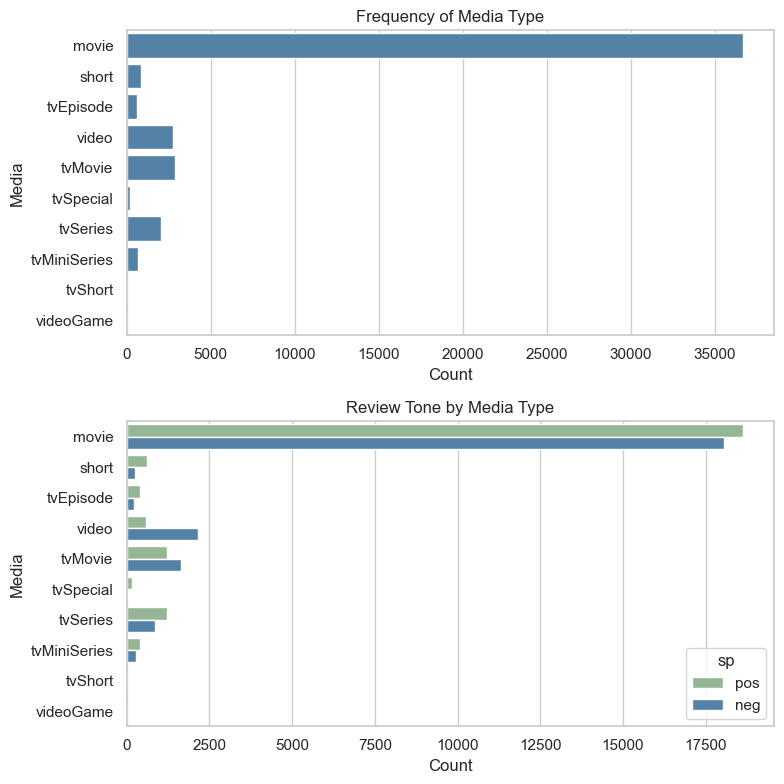

In [16]:
# Graph number of movies and review tone by media type
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Media frequency plot
type_count = sns.countplot(ax=axs[0], data=df_reviews, y='title_type', color='steelblue')
type_count.set(title='Frequency of Media Type', xlabel='Count', ylabel='Media')

# Review tone by media plot
type_review = sns.countplot(ax=axs[1], data=df_reviews, y='title_type', hue='sp', 
                            hue_order=['pos', 'neg'], palette=('darkseagreen', 'steelblue'))
type_review.set(title='Review Tone by Media Type', xlabel='Count', ylabel='Media')

# Show plots
fig.tight_layout()
plt.show()

Most reviews are for movies. There are only a small number of reviews for other media types such as shorts, tv episodes, videos, tv movies, etc. Movies, shorts, tv episodes, and tv series tend to have more positive than negative reviews. Videos and tvmovies have more negative than positive reviews.

### Movies and reviews by year

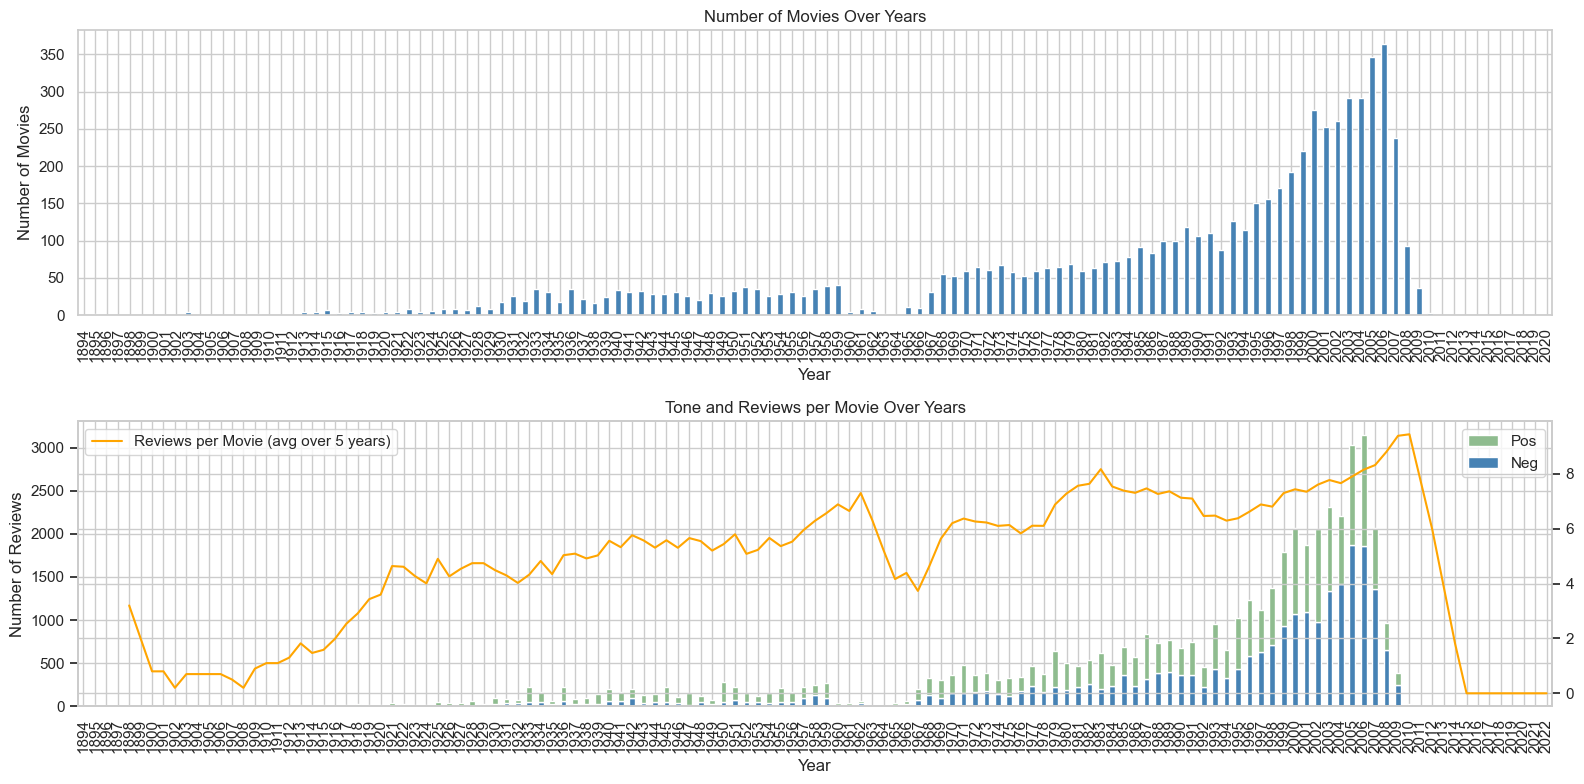

In [71]:
# Create supblots
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# Number of movies by year
ax0 = axs[0]

movies_year = df_reviews.groupby('start_year')['tconst'].nunique()
movies_year = movies_year.reindex(index=np.arange(movies_year.index.min(), 
                                    max(movies_year.index.max(), 2021))).fillna(0)

movies_year.plot(kind='bar', color='steelblue', ax=ax0,
                 title='Number of Movies Over Years', xlabel='Year', 
                 ylabel='Number of Movies')

# Tone of review over time
ax1 = axs[1]

pos_year = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
pos_year = pos_year.reindex(index=np.arange(pos_year.index.min(), 
                                            max(pos_year.index.max(), 2023)), fill_value=0)

pos_year.plot(kind='bar', ax=ax1, stacked=True, color=['steelblue', 'darkseagreen'],
              legend='reverse')

plt.title('Tone and Reviews per Movie Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
ax1.add_artist(ax1.legend(['Neg', 'Pos'], reverse=True))

# Add rolling average reviews per movie over 5 years
axt = ax1.twinx() 

review_total = df_reviews.groupby('start_year')['tconst'].count()
review_total = review_total.reindex(index=np.arange(review_total.index.min(), 
                                                    max(review_total.index.max(), 2023))).fillna(0)
review_movie_year = (review_total / movies_year).fillna(0)

review_movie_year.reset_index(drop=True).rolling(5).mean() \
.plot(kind='line', ax=axt, color='orange', label='Reviews per Movie (avg over 5 years)')

lines, labels = axt.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper left')

# Display figures
fig.tight_layout()
plt.show()

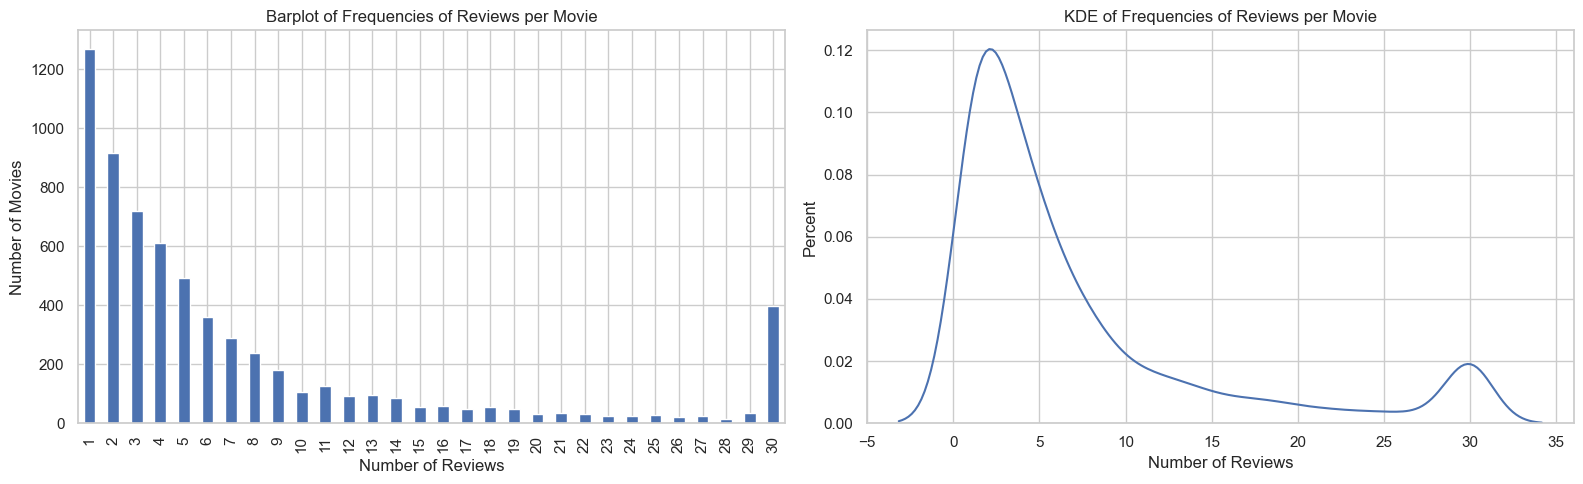

In [91]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

review_movie = df_reviews.groupby('tconst')['review'].count() \
    .value_counts().sort_index()

# Barplot of review per movie frequency
ax0 = axs[0]

review_movie.plot(kind='bar', ax=ax0, title='Barplot of Frequencies of Reviews per Movie',
                  xlabel='Number of Reviews', ylabel='Number of Movies')

# KDE of review per movie frequency
ax1 = axs[1]

review_movie = df_reviews.groupby('tconst')['review'].count()

sns.kdeplot(data=review_movie, ax=ax1)

ax1.set_title('KDE of Frequencies of Reviews per Movie')
ax1.set_xlabel('Number of Reviews')
ax1.set_ylabel('Percent')

# Display
fig.tight_layout()
plt.show()

### Examine class balance

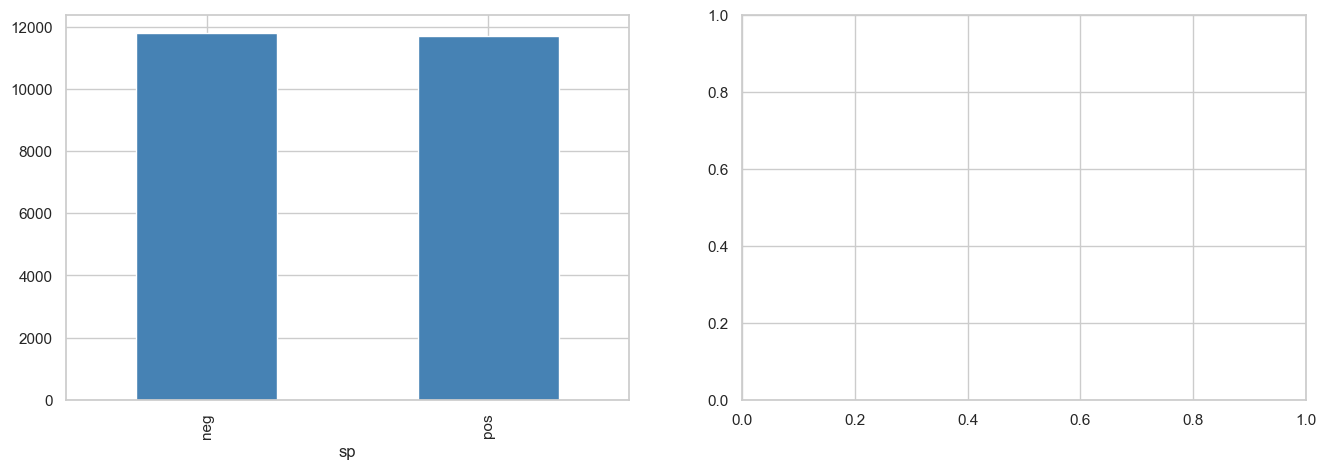

In [105]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax0 = axs[0]

class_train = df_reviews[df_reviews['ds_part'] == 'train']['sp'].value_counts()

class_train.plot(kind='bar', ax=ax0, color='steelblue')

class_test = df_reviews[df_reviews['ds_part'] == 'test']['sp'].value_counts()